<a href="https://colab.research.google.com/github/ibrahim7860/emotiongpt/blob/main/emotionGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Need to do:
  add noise to data to prevent overfit
  mess around w/ batch size & epochs

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.model_selection import train_test_split
from IPython.display import Audio
import warnings

# 新段落

In [2]:
 
# Use google.colab to directly import dataset from Kaggle to colab with out downloading to pc.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Directory to dataset in drive
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"


In [4]:
%cd /content/gdrive/MyDrive/Kaggle

/content/gdrive/MyDrive/Kaggle


make sure dataset is downloaded to proper location
Unzip (skip this step if already done, it takes a while)

In [ ]:
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

toronto-emotional-speech-set-tess.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip "toronto-emotional-speech-set-tess.zip"

Archive:  toronto-emotional-speech-set-tess.zip


Set up for iterating through data

In [5]:
dataset_path = '/content/gdrive/MyDrive/Kaggle/TESS'
emotions_to_labels = {'angry':0, 'disgust':1, 'fear':2, 'happy':3, 'neutral':4, 'sad':5, 'pleasant':6}
paths = []
words = []
actors = []
spects_feature = []
data_labels = []
err_count = 0

check the data and organize it to test and train.

---

Here we look through all the files & extract various features (path, 
spectrogram, associated word, & actor)

---


Note: there's 14 subfolders (1 for each emotion & split between actors)

In [ ]:
# iterate over each subfolder
for subdir, dirs, files in os.walk(dataset_path):
  # iterate over each file in the subfolder
    for file in tqdm(files):
        try:
            # get absolute file path & save
            file_path = os.path.join(subdir, file)
            paths.append(file_path)
            # Load audio file
            audio, sr = librosa.load(file_path, sr=None, mono=True)
            # Extract Mel spectrogram features
            mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
            mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            # Resize to 128x128
            mel_spec.resize((128,128), refcheck=False)
            # Add to data and label lists
            spects_feature.append(mel_spec)
            data_labels.append(emotions_to_labels[subdir.split('_')[1].lower()])

            # tokenify things
            tokens = file.split('_')

            # save word & actor data
            word = tokens[-2]
            words.append(word.lower())
            actor = tokens[0]
            actor = actor.split('/')[-1]
            actors.append(actor)

        except:
            # If there is an error inserting data, report it
            print('Entry error at: ', subdir)
            err_count += 1
            continue


0it [00:00, ?it/s]
100%|██████████| 200/200 [00:12<00:00, 16.57it/s]


Cast the arrays to numpy so there are properly formatted/sized

In [ ]:
spects_feature_np = np.array(spects_feature)
data_labels_np = np.array(data_labels)
spects_feature_np.shape

(2800, 128, 128)

df format is [speech, actors, labels, words, spectrogram]
spectrogram as a numpy array is 128x128.
pandas currently is only saving as a list (need to find a way to save multidimensional arrays for each entry)

In [ ]:
## Create dataframe
df = pd.DataFrame()
df['speech'] = paths
df['actors'] = actors
df['labels'] = data_labels
df['words'] = words
df['spectrogram'] = spects_feature
print(df.head())
print(df.tail())


                                              speech actors  labels  words  \
0  /content/gdrive/MyDrive/Kaggle/TESS/OAF_Fear/O...    OAF       2   back   
1  /content/gdrive/MyDrive/Kaggle/TESS/OAF_Fear/O...    OAF       2    gun   
2  /content/gdrive/MyDrive/Kaggle/TESS/OAF_Fear/O...    OAF       2    gas   
3  /content/gdrive/MyDrive/Kaggle/TESS/OAF_Fear/O...    OAF       2   dime   
4  /content/gdrive/MyDrive/Kaggle/TESS/OAF_Fear/O...    OAF       2  cause   

                                         spectrogram  
0  [[-35.671852, -32.738884, -34.82631, -36.28892...  
1  [[-38.59755, -35.82778, -38.948456, -36.743484...  
2  [[-44.024765, -45.26792, -37.177742, -33.28647...  
3  [[-38.844902, -36.4442, -30.013006, -28.767134...  
4  [[-40.592613, -40.77585, -44.4514, -39.214836,...  
                                                 speech actors  labels  words  \
2795  /content/gdrive/MyDrive/Kaggle/TESS/YAF_sad/YA...    YAF       5  witch   
2796  /content/gdrive/MyDrive/Kaggle/TE

Save numpy arrays & df to a file

In [ ]:
np.save("Spectrogram Features.npy", spects_feature_np)
np.save("Data Labels.npy", data_labels_np)
df.to_pickle('Dataframe.csv')

Use np.load("filename") to retrieve np file information

---

use pd.read_pickle('filename') to retrieve dataframe


In [6]:
spects_feature_np = np.load("Spectrogram Features.npy")
data_labels_np = np.load("Data Labels.npy")
df = pd.read_pickle('Dataframe.csv')

These are quick methods to plot waveplots & spectrograms

In [7]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
     x = librosa.stft(data)
     xdb = librosa.amplitude_to_db(abs(x))
     plt.figure(figsize=(11,4))
     plt.title(emotion, size=20)
     librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
     plt.colorbar()

Create reverse of emotions_to_labels dictionary. 

---

Not any great way to make bidirectional mappings

In [8]:
labels_to_emot = {v: k for k, v in emotions_to_labels.items()}

This is just a test to look at various emotions features

None

back


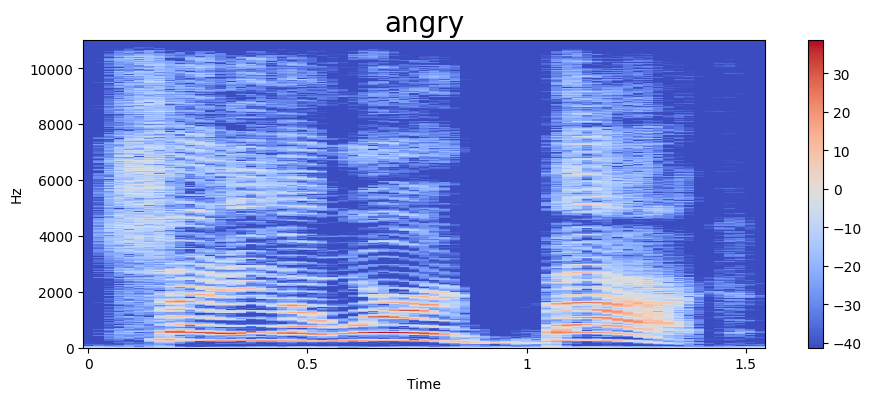

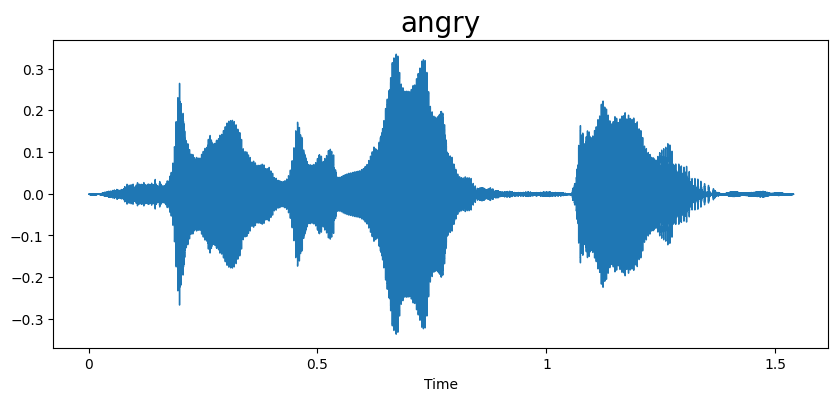

None

back


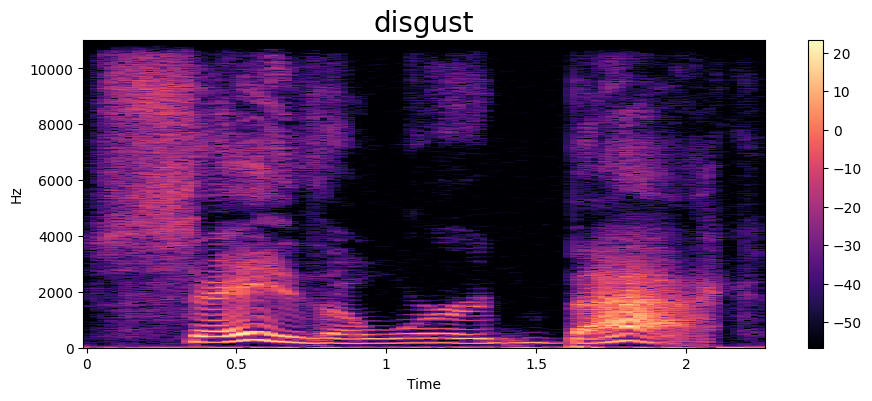

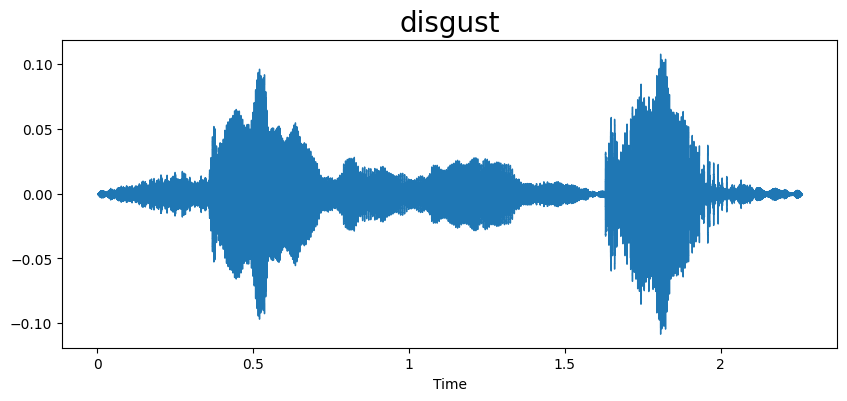

None

back


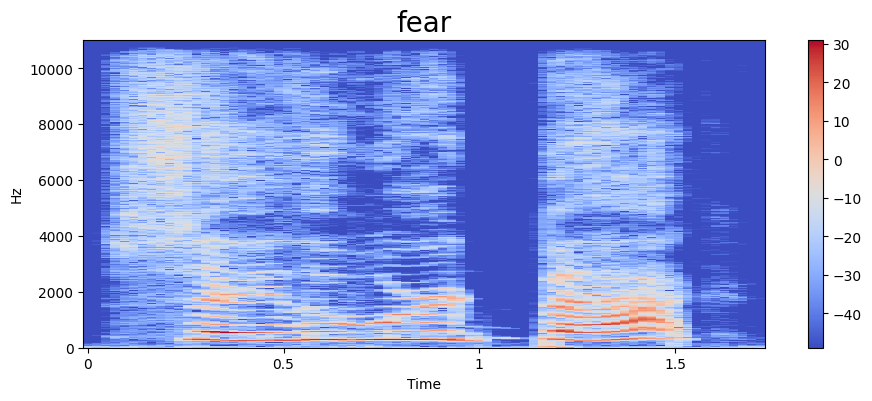

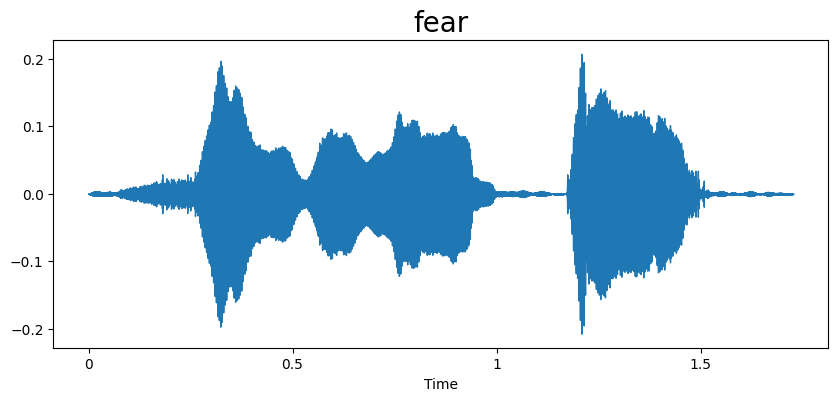

None

back


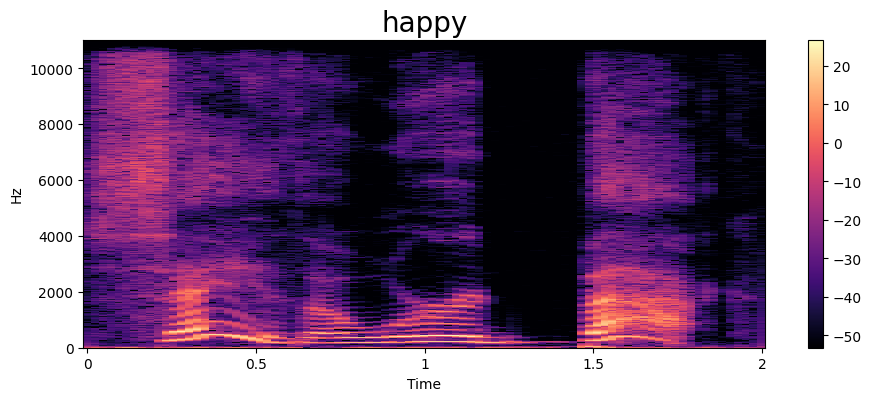

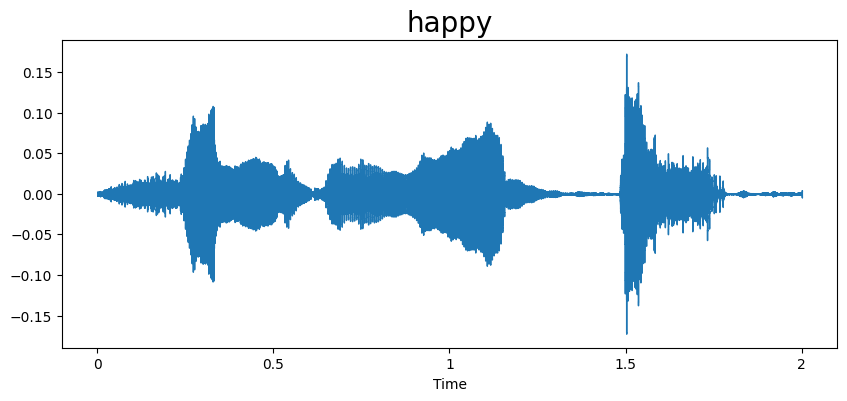

None

back


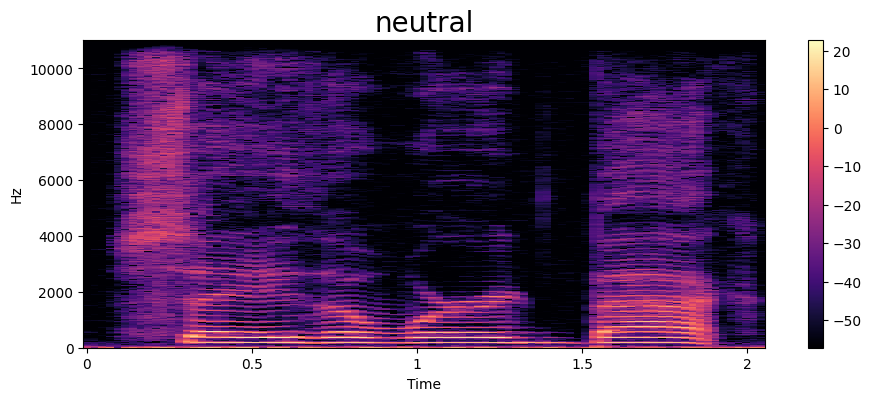

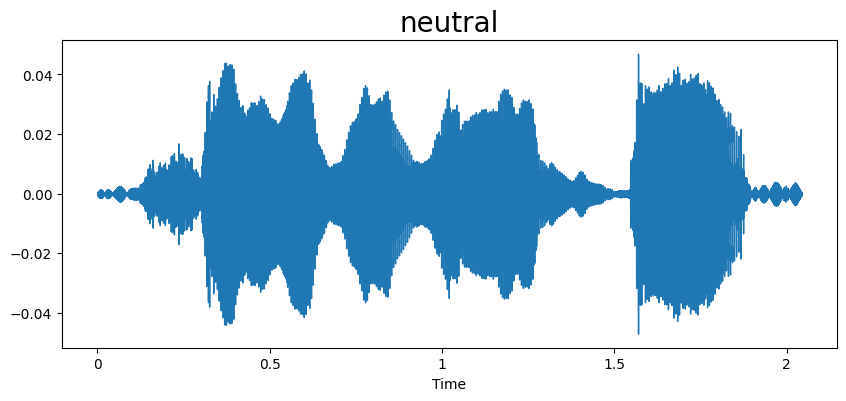

None

back


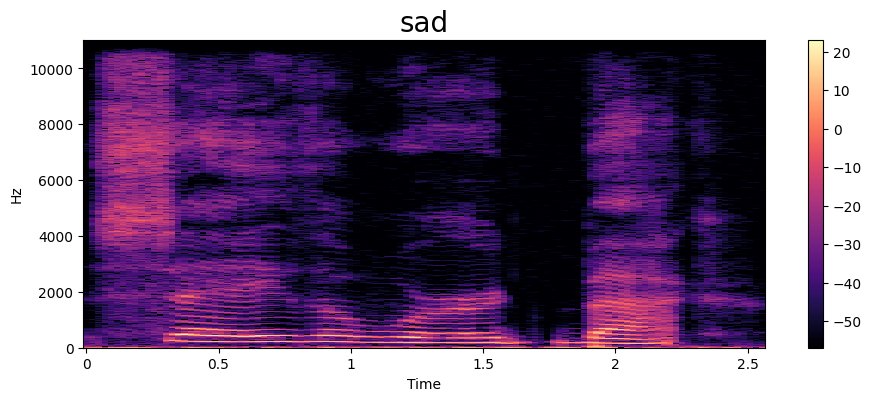

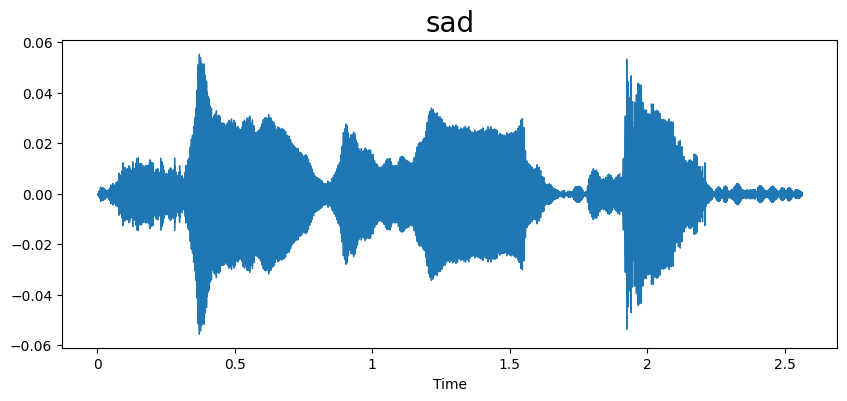

None

back


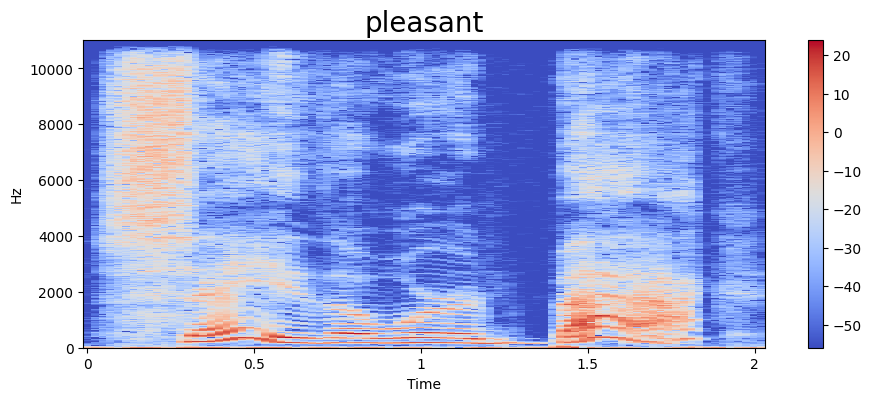

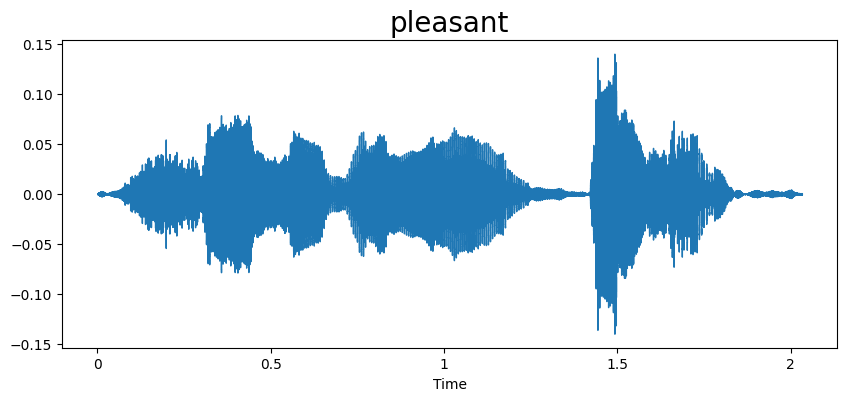

In [9]:
# keeping consistent choice so there isn't too much variance btwn graphs
word_in = 'back'
actor_in = 'OAF'

# create graphs for each emotion for selected word
for emotion in emotions_to_labels:
  # get speech path for each specific column (same actor & word; do for each emotion)
  path = np.array(df[df['actors']==actor_in]['speech'][df['words']==word_in][df['labels']==emotions_to_labels[emotion]])[0]
  word = word_in
  # load stuff
  data, sampling_rate = librosa.load(path)
  # display graph, word, audio file, and waveplot
  display(spectogram(data, sampling_rate, emotion))
  print(word)
  path
  display(Audio(path)) #what this do
  waveplot(data, sampling_rate, emotion) #what this do 

You can use entry_reference.index for a list of all indexes that match the reference
use entry_reference.index[0] if there is only 1 index

In [ ]:
temp = df[df['actors']=='OAF']['speech'][df['words']=='back'].index
temp

Int64Index([0, 200, 400, 600, 800, 1000, 1201], dtype='int64')

This is how you would show spectrogram (or waveplot) for specific entry

None

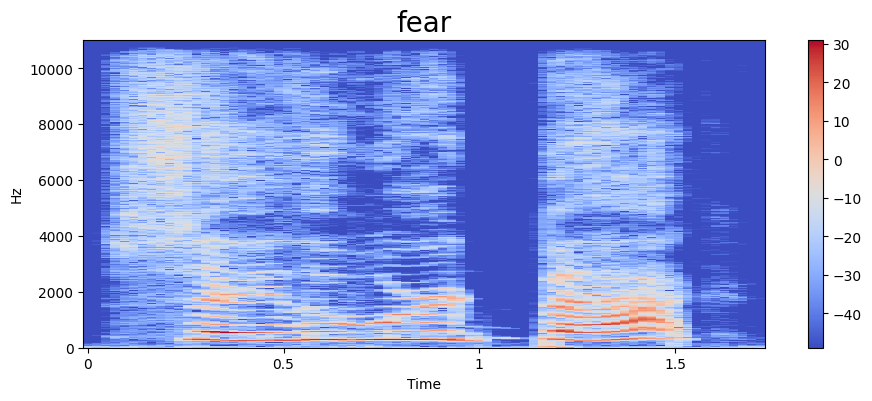

In [ ]:
entry_num = 0
data, sampling_rate = librosa.load(df['speech'][entry_num])
emotion = labels_to_emot[df['labels'][entry_num]]
display(spectogram(data, sampling_rate, emotion))

get rid of error entries

In [ ]:
df = df.dropna()

Split the data & save spectrogram information

In [ ]:
train_spects, test_spects = train_test_split(spects_feature_np, test_size=0.2, train_size=0.8, random_state=25)
train_labels, test_labels = train_test_split(data_labels_np, test_size=0.2, train_size=0.8, random_state=25)

Refit Data for training

In [ ]:
train_spects = train_spects.reshape(-1,128,128,1)
test_spects = test_spects.reshape(-1,128,128,1)

In [ ]:
train_labels[:10]

array([1, 6, 5, 6, 0, 0, 5, 2, 0, 1])

In [ ]:
print(len(train_spects))
print(len(test_spects))

2240
560


Setup CNN model

In [ ]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(128,128,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=7, activation='softmax'))

In [ ]:
model.summary()

Compile model

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Training

In [ ]:
batch_size = 32
epochs = 20

The model runs through a certain number of epochs (or until certain accuracy) (aka iterations that it updates the parameters each time).
It looks over the entire data, but splits the data into batches to limit how much memory it uses.

In [ ]:
train_history = model.fit(x=train_spects, y=train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_spects, test_labels))

Epoch 1/20
70/70 [==============================] - 101s 1s/step - loss: 1.3123 - accuracy: 0.4576 - val_loss: 1.0884 - val_accuracy: 0.5643
Epoch 2/20
70/70 [==============================] - 92s 1s/step - loss: 1.1561 - accuracy: 0.5214 - val_loss: 0.9847 - val_accuracy: 0.5875
Epoch 3/20
70/70 [==============================] - 100s 1s/step - loss: 1.0262 - accuracy: 0.6000 - val_loss: 0.8539 - val_accuracy: 0.6679
Epoch 4/20
70/70 [==============================] - 83s 1s/step - loss: 0.8731 - accuracy: 0.6696 - val_loss: 0.9044 - val_accuracy: 0.6196
Epoch 5/20
70/70 [==============================] - 88s 1s/step - loss: 0.8000 - accuracy: 0.6875 - val_loss: 0.5808 - val_accuracy: 0.7393
Epoch 6/20
70/70 [==============================] - 89s 1s/step - loss: 0.5836 - accuracy: 0.7723 - val_loss: 0.4728 - val_accuracy: 0.7857
Epoch 7/20
70/70 [==============================] - 92s 1s/step - loss: 0.4798 - accuracy: 0.8192 - val_loss: 0.3775 - val_accuracy: 0.8143
Epoch 8/20
70/70 [

Save model

---

Use tf.keras.models.load_model('filename') to retrieve

---

use train_history=np.load('emotionGPT history.npy',allow_pickle='TRUE').item()

In [ ]:
model.save('emotionGPT model.h5')
np.save('emotionGPT history.npy', train_history.history)

Pretty Plotting

In [10]:
model = tf.keras.models.load_model('emotionGPT model.h5')

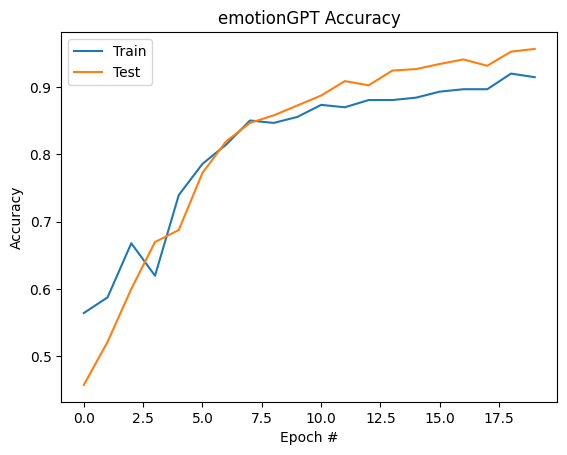

In [11]:
train_history = np.load('emotionGPT history.npy',allow_pickle='TRUE').item()
plt.plot(train_history['val_accuracy'])
plt.plot(train_history['accuracy'])
plt.title('emotionGPT Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()